## Nonlinear pulse propagation

From Hamerly's paper.

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

#The following hack is for importing a module from the "Modules" folder
import os
cwd = os.getcwd()
os.chdir('..')
from Modules.analysis import FTX, IFTX
os.chdir(cwd)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Units
We'll work in the following units:

time = ps <br>
frequency = THz (1/time) <br>
distance = mm

In [2]:
from scipy.constants import pi, c
c = c*1e-9; #mm/ps, [Freq]=THz

In [3]:
#Input parameters
la = 1.5 #um
lb = la/2 #um
L = 40 #mm
alpha = 0.00691 #1/mm
u = 0.329 #ps/mm
Tp = 13.2 #ps
b2a = 1.12e-4 #ps^2/mm
b3a = 3.09e-5 #ps^3/mm
b2b = 4.06e-4
b3b = 2.51e-5
epsilon = 5.16e-5 #ps^0.5/mm
G0 = 3.33
b0 = 3.84e2 #ps^0.5 !?
a0 = 10

p = 1.1 #normalized power
l = 0 #detuning


### Pump

Gaussian pulse:
$$A(t) = exp(-t^2/t_p^2)$$

$$t_p = \frac{t_d}{\sqrt{4 \log{2}}}$$

Sampling Rate = 0.12903225806451246 ps


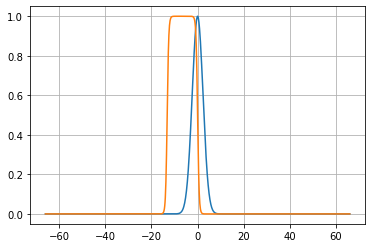

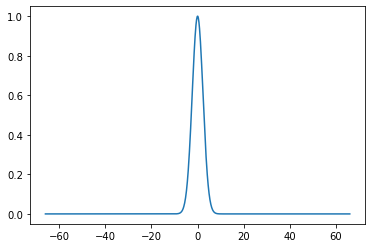

In [4]:
#tp = td/np.sqrt(4*np.log(2)) #tp for Gaussian pulse

N = 1024 #Fourier size
xtra = 5
t = np.linspace(-xtra*Tp, xtra*Tp, N)
ts = t[1]-t[0] #Sampling period
print('Sampling Rate =',ts, 'ps')
Omega = 2*pi*np.fft.fftfreq(t.size, ts)

# b = p*b0*np.exp(-t**2/Tp**2)
Tp1 = -Tp
Tp2 =  0
b = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
a = np.exp(-t**2/(Tp/4)**2)

plt.plot(t,a,t,b)
plt.grid()

b = p*b0*b
plt.figure()
plt.plot(t,a)

### Propagation

In [5]:
h = 0.1 #Distance step Size

#Linear operator (Waveguide)
Da = np.exp((-alpha/2 + 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6)*h)
Db = np.exp((-alpha/2 - 1j*u*Omega + 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6)*h)

In [6]:
b = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
b = b0*p*b
# a = np.exp(-t**2/(Tp/2)**2)
# a = 1.5*a


<IPython.core.display.Javascript object>


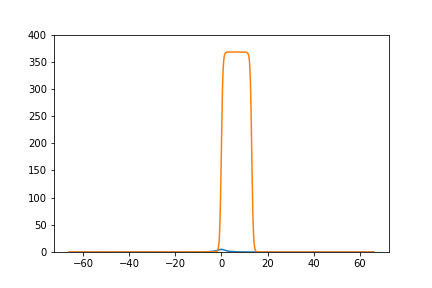

<IPython.core.display.Javascript object>


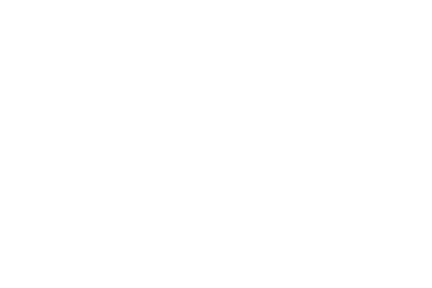

In [10]:
b = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
b = b0*p*b
a = np.exp(-t**2/(Tp/2)**2)
a = 1.1*a

zi = 0

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

while zi<L:
    #Linear half step
    A = np.fft.fft(a)
    A = A*Da
    a = np.fft.ifft(A)
    
    B = np.fft.fft(b)
    B = B*Db
    b = np.fft.ifft(B)
    
    #Nonlinear step
    Na = epsilon*b*np.conj(a)
    a = a*np.exp(h*Na)
    Nb = -0.5*epsilon*a*a
    b = b + Nb*h
    
    #Next z
    zi = zi+h
    
    if zi%2<0.1:
        ax.clear()
        ax.plot(t, abs(a), t, abs(b));
        ax.axes.set_ylim(0,400)
        fig.canvas.draw()
        time.sleep(0.001)
    
# plt.plot(t, abs(a), t, abs(b));
# plt.figure()
# plt.plot(t, abs(a));

## OPO

<IPython.core.display.Javascript object>


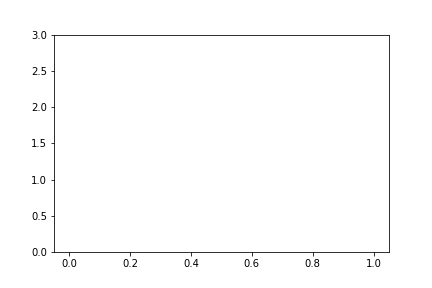

C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in exp
C:\Users\luish\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in multiply


<IPython.core.display.Javascript object>


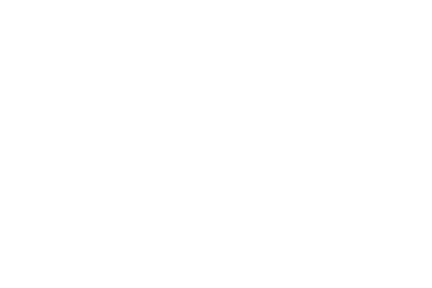

In [21]:
N = 5 #loops

b_shape = -1/(1+np.exp(3*(t-Tp1)))+1/(1+np.exp(3*(t-Tp2)))
a_shape = np.exp(-t**2/(Tp/2)**2)
a = a_shape

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

for kn in range(N):
    zi = 0
    b = b0*p*b_shape
    while zi<L:
        #Linear half step
        A = np.fft.fft(a)
        A = A*Da
        a = np.fft.ifft(A)

        B = np.fft.fft(b)
        B = B*Db
        b = np.fft.ifft(B)

        #Nonlinear step
        ar = np.real(a)
        ai = np.imag(a)
        Nar = epsilon*b*ar
        Nai = -epsilon*b*ai
        a = ar*np.exp(h*Nar) + 1j*ai*np.exp(h*Nai)
        Nb = -0.5*epsilon*a*a
        b = b + Nb*h

        #Next z
        zi = zi+h

        if zi%2<0.1:
            ax.clear()
#             ax.plot(t, abs(a), t, abs(b));
            ax.plot(t, abs(a));
            ax.axes.set_ylim(0,3)
            fig.canvas.draw()
            time.sleep(0.001)
            
        #Feedback
#         a = a/G0
        a = a/1.001
    